### Mean-field limits

This notebook discusses the behavior of the CNVM as we let the number of nodes $N$ increase.
For certain networks, e.g., complete and Erdös-Rényi networks, it is known that the dynamics of the CNVM converges to a mean-field limit given by an ordinary differential equation (ODE) of the opinion shares.
This ODE is also called mean-field equation or reaction-rate equation (RRE) and is defined as
$$ \frac{d}{dt} c(t) = \sum_{\substack{m,n=1 \\ m\neq n}}^M c_m(t) (r_{mn} c_n(t) + \tilde{r}_{mn})(e_n - e_m), \quad \text{(RRE)} $$
where $c(t)=(c_1(t), \dots, c_M(t))$ is the vector of opinion shares (e.g., $c_1(t) \in [0,1]$ is the share of nodes in state $1$), and $e_n$ is the $n$-th unit vector.
(The proof can be found for example in [[Lücke et al., 2022]](https://arxiv.org/abs/2210.02934).)

We show how to investigate this phenomenon using the CNVM package.
First we do the necessary imports.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cnvm import Parameters
from cnvm.collective_variables import OpinionShares
from cnvm.network_generator import ErdosRenyiGenerator
from cnvm.utils import sample_many_runs, calc_rre_traj

We will use the following example parameters.

In [2]:
num_opinions = 3
t_max = 100

r = np.array([[0, .8, .2],
              [.2, 0, .8],
              [.8, .2, 0]])
r_tilde = 0.01 * np.array([[0, .9, .7],
                           [.7, 0, .9],
                           [.9, .7, 0]])

cv = OpinionShares(num_opinions, normalize=True)

Now we conduct a statistical analysis of the CNVM for Erdös-Rényi (ER) networks ($p=0.1$) of different sizes.
We sample multiple realizations for networks of sizes $N=200,1000,5000$ using the `sample_many_runs` function.
The initial state is picked such that 40\% of nodes have state 0, 20\% state 1, and 40\% state 2.
Moreover, we use a `NetworkGenerator` object to generate a new ER network for each sample.

(If the following code block takes long on your machine, try reducing the `num_samples`.)

In [3]:
num_agents = [200, 1000, 5000]
num_samples = [500, 100, 10]
c_list = []

for n_a, n_samples in zip(num_agents, num_samples):
    network_gen = ErdosRenyiGenerator(n_a, p=0.1)

    params = Parameters(
        num_opinions=num_opinions,
        network_generator=network_gen,
        r=r,
        r_tilde=r_tilde,
    )

    x_init = np.zeros((1, n_a))
    x_init[0, :int(0.2 * n_a)] = 1
    x_init[0, int(0.6 * n_a):] = 2

    t, c = sample_many_runs(params, x_init, t_max, 10 * t_max, n_samples, collective_variable=cv)
    c_list.append(c[0])

The CNVM package offers the function `calc_rre_traj` that calculates the solution of the mean-field ODE for us.

In [4]:
t_rre, c_rre = calc_rre_traj(params, c_list[-1][0, 0, :], t_max, t_eval=t)

Finally, we compare the results from our simulations to the solution of the RRE.
As the theory suggests, a larger number of nodes yields a closer match between the average simulation and the RRE.

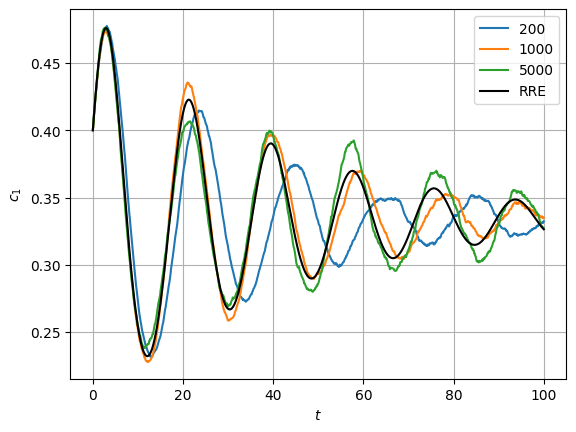

In [6]:
for n_a, c in zip(num_agents, c_list):
    plt.plot(t, np.mean(c[:, :, 0], axis=0), label=f"{n_a}")
plt.plot(t_rre, c_rre[:, 0], "k", label="RRE")
plt.grid()
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$c_1$")
plt.show()